In [2]:
import re
import os
import sys
import time
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
from numpy.linalg import *
from scipy.linalg import *
from mindquantum.simulator import *
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindquantum.algorithm.compiler import *

np.set_printoptions(linewidth=200)

[[ 0.737037  +0.67021726j -0.05195395+0.06990044j  0.        +0.j        ]
 [-0.01504022-0.08578505j -0.95948408+0.26796458j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j        ]]
[[ 0.737037  +0.67021726j -0.03673699+0.04942707j -0.03673699+0.04942707j  0.        +0.j        ]
 [-0.01063504-0.06065919j  0.02025796+0.13398229j -0.97974204+0.13398229j  0.        +0.j        ]
 [-0.01063504-0.06065919j -0.97974204+0.13398229j  0.02025796+0.13398229j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          1.        +0.j        ]]
True


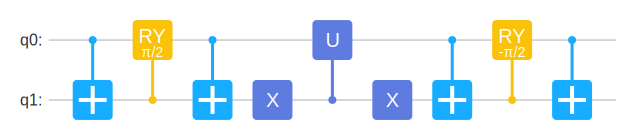

In [4]:
def Rd(name, d, t, ind):
    mat = np.eye(d, dtype=np.complex128)
    if name == 'X':
        mat[np.ix_(ind, ind)] = RX(t).matrix()
    elif name == 'Y':
        mat[np.ix_(ind, ind)] = RY(t).matrix()
    elif name == 'Z':
        mat[np.ix_(ind, ind)] = RZ(t).matrix()
    return mat


d = 3
t = np.pi / 2

ind = [0, 1]
# R = Rd('Y', d, t, ind)
U = unitary_group.rvs(2)
if ind == [0, 1]:
    R = block_diag(U, 1)
elif ind == [0, 2]:
    R = np.eye(d, dtype=np.complex128)
    R[np.ix_(ind, ind)] = U
elif ind == [1, 2]:
    R = block_diag(1, U)
print(R)

p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
Re = su2_encoding(R)
Rp = Re + p
# print(Re)
# print(Rp)

circ = Circuit()
corr = Circuit()
if ind == [0, 1]:
    corr = corr + X(1, 0) + RY(np.pi / 2).on(0, 1) + X(1, 0) + X(1)
elif ind == [0, 2]:
    corr = corr + X(0) + X(1, 0) + X(0)
elif ind == [1, 2]:
    corr = corr + X(1, 0) + RY(-np.pi / 2).on(0, 1) + X(1, 0)
circ += corr
# circ += RY(t).on(0, 1)
circ += UnivMathGate('U', U).on(0, 1)
circ += corr.hermitian()
print(circ.matrix())
print(np.allclose(Rp, circ.matrix()))
circ.svg()

1¦00⟩
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
√2/2¦10⟩
√2/2¦11⟩
[0.        +0.j 0.        +0.j 0.70710678+0.j 0.70710678+0.j]
[[ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.70710678+0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]]


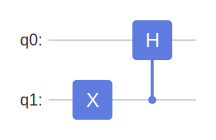

In [4]:
circ = Circuit() + X(1) + H(0, 1)
# + X(1, 0) + X(0)
sim = Simulator('mqvector', 2)
# sim.set_qs(np.array([0, 1, 1, 0]))
str_ket(2, sim.get_qs())
sim.apply_circuit(circ)
str_ket(2, sim.get_qs())
print(circ.matrix())
circ.svg()

In [53]:
d = 3
p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
q = {i: np.eye(d)[i] for i in range(d)}
INC = np.eye(d)
INC = INC[[d - 1] + list(range(d - 1))]
# INC = INC @ INC
state = q[0] + q[1]
state /= norm(state)
str_ket(d, state)
str_ket(d, INC @ state)
print(INC)

INCe = su2_encoding(INC)
INCp = INCe + p
# print(INCe)
print(INCp)
str_ket(2, su2_encoding(state))
str_ket(2, INCp @ su2_encoding(state))

√2/2¦0⟩
√2/2¦1⟩
[0.70710678 0.70710678 0.        ]
√2/2¦1⟩
√2/2¦2⟩
[0.         0.70710678 0.70710678]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.70710678+0.j  0.5       +0.j -0.5       +0.j  0.        +0.j]
 [ 0.70710678+0.j -0.5       +0.j  0.5       +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]]
√2/2¦00⟩
1/2¦01⟩
1/2¦10⟩
[0.70710678+0.j 0.5       +0.j 0.5       +0.j 0.        +0.j]
1/2¦01⟩
1/2¦10⟩
√2/2¦11⟩
[0.        +0.j 0.5       +0.j 0.5       +0.j 0.70710678+0.j]


Number of qubits: 3
Number of params: 64
Number of gates: 34
Optimal Gap: 0.63885924202520771864, 10, 0.0060
Optimal Gap: 0.57443858388968671580, 20, 0.0114
Optimal Gap: 0.44925832148416111611, 30, 0.0164
Optimal Gap: 0.29324451872611123626, 40, 0.0216
Optimal Gap: 0.19360434875522603004, 50, 0.0271
Optimal Gap: 0.08328861443884405524, 60, 0.0319
Optimal Gap: 0.00296535988944490736, 70, 0.0375
Optimal Gap: 0.00195636214713146295, 80, 0.0428
Optimal Gap: 0.00042840435800339804, 90, 0.0477
Optimal Gap: 0.00000097909808205454, 100, 0.0525
Optimal Gap: 0.00000000149820800210, 110, 0.0579
Converged (|f_n-f_(n-1)| ~= 0)
Optimal Value: 0.00000000067087935207
psi norm: 1.50914289832234427280
psi fidelity: 0.99999999966456021294


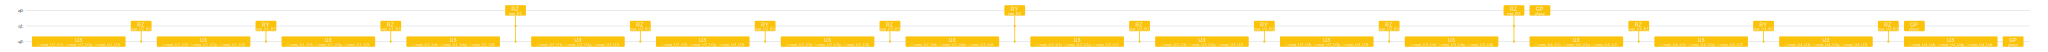

In [2]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Optimal Gap: %.20f, %d, %.4f' % (f, i, t))
    return f, g


def symmetric_ansatz(gate: UnivMathGate):
    obj = gate.obj_qubits
    circ = Circuit()
    name = f'{gate.name}_'
    if len(obj) == 2:
        circ += U3(f'{name}U1t', f'{name}U1p', f'{name}U1l').on(obj[1])
        circ += RZ(f'{name}R1').on(obj[0], obj[1])
        circ += U3(f'{name}U2t', f'{name}U2p', f'{name}U2l').on(obj[1])
        circ += RY(f'{name}R2').on(obj[0], obj[1])
        circ += U3(f'{name}U3t', f'{name}U3p', f'{name}U3l').on(obj[1])
        circ += RZ(f'{name}R3').on(obj[0], obj[1])
        circ += U3(f'{name}U4t', f'{name}U4p', f'{name}U4l').on(obj[1])
    else:
        n = 2**len(obj[1:])
        circ += symmetric_ansatz(UnivMathGate(f'{name}U1', np.eye(n)).on(obj[1:]))
        circ += RZ(f'{name}R1').on(obj[0], obj[1:])
        circ += symmetric_ansatz(UnivMathGate(f'{name}U2', np.eye(n)).on(obj[1:]))
        circ += RY(f'{name}R2').on(obj[0], obj[1:])
        circ += symmetric_ansatz(UnivMathGate(f'{name}U3', np.eye(n)).on(obj[1:]))
        circ += RZ(f'{name}R3').on(obj[0], obj[1:])
        circ += symmetric_ansatz(UnivMathGate(f'{name}U4', np.eye(n)).on(obj[1:]))
    return circ


d, m = 2, 3
nq = (d - 1) * m
Id = su2_encoding(np.eye(d**m), m)
p = np.eye(Id.shape[0]) - Id

mat = unitary_group.rvs(d**m)
mat = su2_encoding(mat, m) + p
gate = UnivMathGate('mat', mat).on(list(range(nq)))

sim = Simulator('mqvector', nq)
sim.apply_gate(gate)
psi = sim.get_qs()
ham = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(ham))

ansatz = symmetric_ansatz(gate)
for i in range(nq):
    ansatz += GlobalPhase(f'phase').on(i)
p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='TNC', jac=True, tol=1e-8)

print(res.message)
print('Optimal Value: %.20f' % res.fun)

sim.reset()
res_pr = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(res_pr))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))

display_svg(ansatz.svg())
# ansatz.apply_value(res_pr).svg()

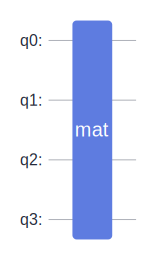

Number of qubits: 4
Number of params: 34
Number of gates: 21
Optimal Gap: 0.71681190191923438437, 10, 0.0059
Optimal Gap: 0.28595931871731283813, 20, 0.0105
Optimal Gap: 0.25519645319872785727, 30, 0.0153
Optimal Gap: 0.24218814843158387173, 40, 0.0209
Optimal Gap: 0.20842981656107828492, 50, 0.0268
Optimal Gap: 0.15619702622628606203, 60, 0.0321
Optimal Gap: 0.09591526637477376660, 70, 0.0370
Optimal Gap: 0.05806441361071534857, 80, 0.0418
Optimal Gap: 0.04719733226907285584, 90, 0.0465
Optimal Gap: 0.03957978752032187408, 100, 0.0512
Optimal Gap: 0.03507313029767766821, 110, 0.0562
Optimal Gap: 0.03306089341250262326, 120, 0.0619
Optimal Gap: 0.03299492038180573683, 130, 0.0669
Optimal Gap: 0.03299401964851378377, 140, 0.0724
Optimal Gap: 0.03299398670925368648, 150, 0.0774
Converged (|f_n-f_(n-1)| ~= 0)
Optimal Value: 0.03299398580390244806
Is state symmetric: True False
psi norm: 1.53659784526594411780
psi fidelity: 0.98336463948837293803


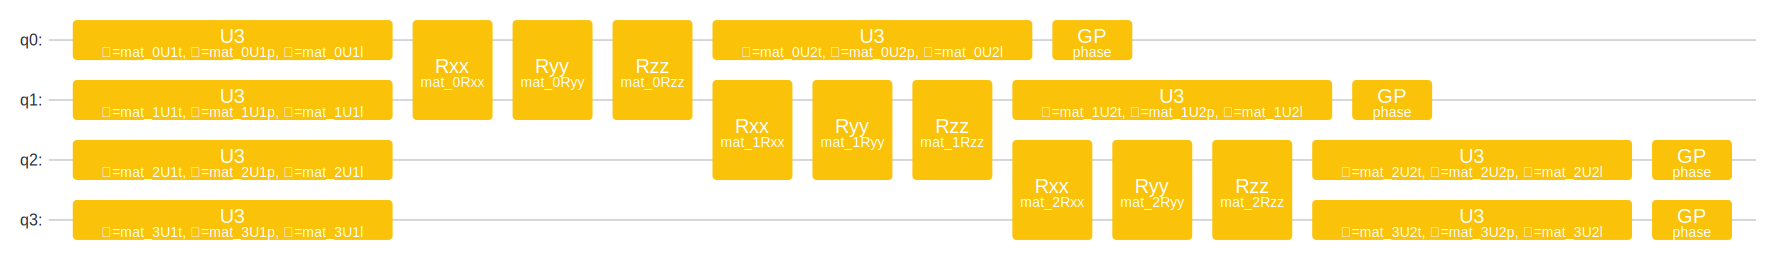

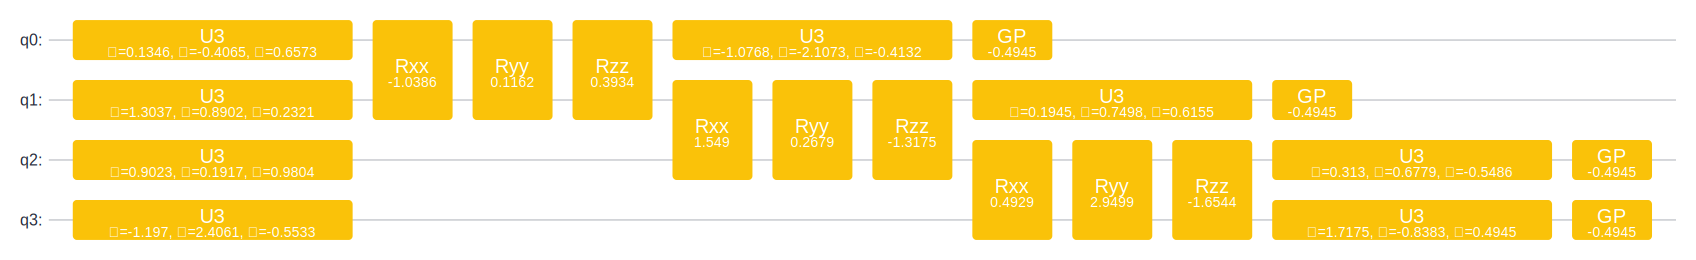

In [3]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Optimal Gap: %.20f, %d, %.4f' % (f, i, t))
    return f, g


def qutrit_symmetric_ansatz(gate: UnivMathGate):
    obj = gate.obj_qubits
    name = f'{gate.name}_'
    circ = Circuit()
    for i in obj:
        circ += U3(f'{name}{i}U1t', f'{name}{i}U1p', f'{name}{i}U1l').on(i)
    for i in range(3):
        circ += Rxx(f'{name}{i}Rxx').on([obj[i], obj[i + 1]])
        circ += Ryy(f'{name}{i}Ryy').on([obj[i], obj[i + 1]])
        circ += Rzz(f'{name}{i}Rzz').on([obj[i], obj[i + 1]])
    for i in obj:
        circ += U3(f'{name}{i}U2t', f'{name}{i}U2p', f'{name}{i}U2l').on(i)
        circ += GlobalPhase(f'phase').on(i)
    return circ


d, m = 3, 2
nq = (d - 1) * m
Id = su2_encoding(np.eye(d**m), m)
p = np.eye(Id.shape[0]) - Id

circ = Circuit()
ansatz = Circuit()
mat = mat = unitary_group.rvs(d**m)
mat = su2_encoding(mat, m) + p
obj = list(range(nq))
gate = UnivMathGate(f'mat', mat).on(obj)
circ += gate
ansatz += qutrit_symmetric_ansatz(gate)
# for i in range(2):
#     mat = unitary_group.rvs(d**m)
#     mat = su2_encoding(mat, m) + c
#     obj = list(range(2*i, nq + 2*i))
#     print(obj)
#     gate = UnivMathGate(f'mat{i}', mat).on(obj)
#     circ += gate
#     ansatz += one_qutrit_symmetric_ansatz(gate)
display_svg(circ.svg())

nq = circ.n_qubits
sim = Simulator('mqvector', nq)
sim.apply_gate(gate)
psi = sim.get_qs()
ham = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(ham))

p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='TNC', jac=True, tol=1e-8)

print(res.message)
print('Optimal Value: %.20f' % res.fun)

sim.reset()
res_pr = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(res_pr))
psi_res = sim.get_qs()
print('Is state symmetric:', is_symmetric(psi, 2), is_symmetric(psi_res, 2))
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))

display_svg(ansatz.svg())
ansatz.apply_value(res_pr).svg()

True


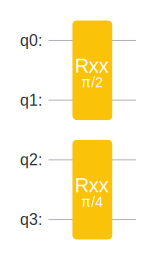

In [6]:
d, m = 3, 2
nq = (d - 1) * m
Id = su2_encoding(np.eye(d))
c = np.eye(Id.shape[0]) - Id

a = np.random.rand(d**m) + 1j * np.random.rand(d**m)
a /= norm(a)
a = su2_encoding(a, m)

sim = Simulator('mqvector', nq)
sim.set_qs(a)

t = np.pi / 2
circ = Circuit() + Rxx(t).on([0, 1]) + Rxx(t / 2).on([2, 3])

sim.apply_circuit(circ)
psi = sim.get_qs()
print(is_symmetric(psi, m))

circ.svg()

In [7]:
d, m = 3, 2
nq = (d - 1) * m
n = 2**nq
sym_ind(3, 2)

ind_ = {}
for i in range(2**(d - 1)):
    num1 = bin(i).count('1')
    i_ = bin(i)[2::].zfill(d - 1)
    if num1 in ind_:
        ind_[num1].append(i_)
    else:
        ind_[num1] = [i_]
for i in range(d**m):
    multi = ['']
    base = np.base_repr(i, d).zfill(m)
    for j in range(m):
        multi = [x + y for x in multi for y in ind_[int(base[j])]]
    print(f'{i}|{base}⟩ -> ', end='')
    for j in multi:
        print(f'|{j}⟩ ', end='')
        # print(f'{int(j, 2)}|{j}⟩ ', end='')
    print()

0|00⟩ -> |0000⟩ 
1|01⟩ -> |0001⟩ |0010⟩ 
2|02⟩ -> |0011⟩ 
3|10⟩ -> |0100⟩ |1000⟩ 
4|11⟩ -> |0101⟩ |0110⟩ |1001⟩ |1010⟩ 
5|12⟩ -> |0111⟩ |1011⟩ 
6|20⟩ -> |1100⟩ 
7|21⟩ -> |1101⟩ |1110⟩ 
8|22⟩ -> |1111⟩ 


In [3]:
# Qudit
d = 3
nq = d - 1
n = 2**nq
for i in range(d):
    for j in range(d):
        a = f'a{str(i)}{str(j)}|{str(i)}⟩⟨{str(j)}|'
        print(a, end=' ')
    print()
print()
# Qubit
for i in range(n):
    for j in range(n):
        ii = bin(i)[2:].zfill(nq)
        jj = bin(j)[2:].zfill(nq)
        a = f'a{str(i)}{str(j)}|{ii}⟩⟨{jj}|'
        print(a, end=' ')
    print()

a00|0⟩⟨0| a01|0⟩⟨1| a02|0⟩⟨2| 
a10|1⟩⟨0| a11|1⟩⟨1| a12|1⟩⟨2| 
a20|2⟩⟨0| a21|2⟩⟨1| a22|2⟩⟨2| 

a00|00⟩⟨00| a01|00⟩⟨01| a02|00⟩⟨10| a03|00⟩⟨11| 
a10|01⟩⟨00| a11|01⟩⟨01| a12|01⟩⟨10| a13|01⟩⟨11| 
a20|10⟩⟨00| a21|10⟩⟨01| a22|10⟩⟨10| a23|10⟩⟨11| 
a30|11⟩⟨00| a31|11⟩⟨01| a32|11⟩⟨10| a33|11⟩⟨11| 


In [4]:
# Qudit
d = 4
nq = d - 1
n = 2**nq
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(i)}{str(j)}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')
print()
# Qubit
ind = {}
for i in range(n):
    num1 = bin(i).count('1')
    ind[i] = [num1]
print(ind)
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(ind[i][0])}{str(ind[j][0])}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')

\begin{pmatrix}
a_{00} & a_{01} & a_{02} & a_{03} \\
a_{10} & a_{11} & a_{12} & a_{13} \\
a_{20} & a_{21} & a_{22} & a_{23} \\
a_{30} & a_{31} & a_{32} & a_{33} \\
\end{pmatrix}

{0: [0], 1: [1], 2: [1], 3: [2], 4: [1], 5: [2], 6: [2], 7: [3]}
\begin{pmatrix}
a_{00} & a_{01} & a_{01} & a_{02} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{20} & a_{21} & a_{21} & a_{22} \\
\end{pmatrix}


In [5]:
d = 3
n = 2**(d - 1)
a1 = unitary_group.rvs(d)
a2 = su2_encoding(a1)
print(a1)
print(a2)
p = np.eye(n) - su2_encoding(np.eye(d))
print(p)
a2 += p
is_unitary(a2), is_symmetric(a2)

[[ 0.57545538+0.16590746j -0.60864031+0.26254676j  0.43029052-0.12962278j]
 [-0.10319062-0.66173937j -0.00385583-0.3116642j   0.64081083+0.20896109j]
 [-0.32373878+0.29660028j  0.26535201+0.626949j    0.43109755+0.39736589j]]
[[ 0.57545538+0.16590746j -0.43037369+0.1856486j  -0.43037369+0.1856486j   0.43029052-0.12962278j]
 [-0.07296679-0.4679204j  -0.00192792-0.1558321j  -0.00192792-0.1558321j   0.45312168+0.1477578j ]
 [-0.07296679-0.4679204j  -0.00192792-0.1558321j  -0.00192792-0.1558321j   0.45312168+0.1477578j ]
 [-0.32373878+0.29660028j  0.1876322 +0.44331989j  0.1876322 +0.44331989j  0.43109755+0.39736589j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, False)

In [6]:
d = 3
n = 2**(d - 1)
i1 = np.eye(d)
i2 = su2_encoding(i1)
p = np.eye(n) - su2_encoding(np.eye(d))
print(i1)
print(i2)
print(p)
is_symmetric(i2), matrix_rank(i2)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 1. +0.j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, 3)

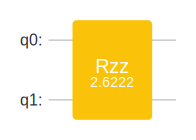

(True, True, True)

In [7]:
# U2⊗U2 Rxx Ryy Rzz SWAP preserve symmetry
d = 3
a1 = unitary_group.rvs(d)
b1 = np.random.rand(d) + 1j * np.random.rand(d)
b1 /= norm(b1)
a2 = su2_encoding(a1)
b2 = su2_encoding(b1)
# print(a1)
# print(a2)
# print(b1)
# print(b2)
t = np.random.uniform(-np.pi, np.pi)
k = Circuit() + Rzz(t).on([0, 1])
# k = Circuit() + UN(UnivMathGate('', unitary_group.rvs(2)), 2)
display_svg(k.svg())
k = k.matrix()
# print(k)
# print(a2 @ k)
# print(k @ a2)
# print(k @ b2)
is_symmetric(a2 @ k), is_symmetric(k @ a2), is_symmetric(k @ b2)

In [8]:
# How to restore a reduce density matrix
np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
b = np.random.rand(2) + 1j * np.random.rand(2)
a /= norm(a)
b /= norm(b)
psi_ab = np.kron(a, b)
rho_a = np.outer(a, a.conj())
rho_b = np.outer(b, b.conj())
rho_ab = np.kron(rho_a, rho_b)
print(rho_a)
print(rho_b)
print(rho_ab)
print(psi_ab.conj() @ rho_ab @ psi_ab)
fidelity(rho_ab, psi_ab)

[[0.34880034+0.j         0.40977999+0.24334959j]
 [0.40977999-0.24334959j 0.65119966+0.j        ]]
[[0.03454462+0.j         0.0930421 -0.15714469j]
 [0.0930421 +0.15714469j 0.96545538+0.j        ]]
[[ 1.20491735e-02+0.j          3.24531155e-02-0.05481212j  1.41556919e-02+0.00840642j  7.63678855e-02-0.04175299j]
 [ 3.24531155e-02+0.05481212j  3.36751167e-01+0.j         -1.14305675e-04+0.0870365j   3.95624296e-01+0.23494318j]
 [ 1.41556919e-02-0.00840642j -1.14305675e-04-0.0870365j   2.24954416e-02+0.j          6.05889828e-02-0.10233257j]
 [ 7.63678855e-02+0.04175299j  3.95624296e-01-0.23494318j  6.05889828e-02+0.10233257j  6.28704218e-01+0.j        ]]
(1.0000000000000007+0j)


1.0000000000000002